This is model, where we should do binary classification - predict probability of A

   1) num_classes - number of classes
   
   2) each class has its popability of A
   
   3) prob - array of these probabilities; they are Q - coordinates for Hamiltonian MCMC
   
   4) prior (alpha, beta) are two float variables describing beta-distribution classes' popabilities.

In [134]:
! python --version

Python 3.5.2


In [73]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from matplotlib.cm import rainbow
import collections
from tqdm import tqdm_notebook as tqdm
import scipy.stats as sps

import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output

%matplotlib inline


tfd = tfp.distributions

In [2]:
def reset_tf():
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tf.reset_default_graph()
        try:
            sess.close()
        except:
            pass
        sess = tf.InteractiveSession()
        
    return sess

In [3]:
def get_example_data():
    ps_data_arr = np.array([
        [20, 10, 1, 0.499993], [20, 3, 2, 0.230211], [20, 8, 3, 0.236831], 
        [20, 7, 4, 0.246463], [20, 6, 5, 0.370862], [20, 5, 6, 0.320656], 
        [20, 10, 7, 0.519887], [20, 12, 8, 0.52845], [20, 8, 9, 0.453077], 
        [20, 8, 10, 0.431245], [20, 10, 11, 0.499243], [20, 9, 12, 0.471968], 
        [20, 2, 13, 0.152176], [20, 14, 14, 0.48496], [20, 6, 15, 0.246193]
    ])
    ps_data_pd=pd.DataFrame(data=ps_data_arr[0:, 0:],
             index=ps_data_arr[0:, 2],
             columns=["total_count", "clicks", "class_id", "true_p"],
             dtype=np.float32)
    ps_data_pd['class_id'] = ps_data_pd.class_id.astype('int32')
    
    return ps_data_pd

In [4]:
def sample_data(classes=15, alpha=1, beta=10, samples=20):
    p = np.random.beta(alpha, beta, size=classes)
    clicks = np.random.binomial(samples, p)
    
    ps_data_arr = np.array([
        [samples, clicks[i], i + 1, p[i]] for i in range(classes)
    ])
    
    ps_data_pd=pd.DataFrame(data=ps_data_arr[0:, 0:],
             index=ps_data_arr[0:, 2],
             columns=["total_count", "clicks", "class_id", "true_p"],
             dtype=np.float32)
    ps_data_pd['class_id'] = ps_data_pd.class_id.astype('int32')
    
    return ps_data_pd

In [121]:
def sample_alpha_and_beta(ps_data_pd, sample_size, num_burnin_steps, num_steps_between_results, num_leapfrog_steps, adaptation_steps):
    
    sess = reset_tf()

    def _make_ps_prior(num_classes, alpha, beta, dtype):
        return tfd.Independent(
          tfd.Beta(
              alpha * tf.ones(num_classes),
              beta * tf.ones(num_classes)),
              reinterpreted_batch_ndims=1)

    def _make_ps_log_likelihood(prob, class_id, total_count):
        prob_c = tf.gather(prob, indices=tf.to_int32(class_id - 1), axis=-1)
        total_count_c = tf.gather(total_count, indices=tf.to_int32(class_id - 1), axis=-1)
        return tfp.distributions.Binomial(total_count=tf.to_float(total_count_c), probs=prob_c)
    
    make_ps_prior = tf.make_template(name_='make_ps_prior', func_=_make_ps_prior)
    make_ps_log_likelihood = tf.make_template(name_='make_ps_log_likelihood', func_=_make_ps_log_likelihood)
    
    def joint_log_prob(prob, alpha, beta, total_count, clicks, class_id, dtype):
        num_classes = len(total_count)
        rv_prob = make_ps_prior(num_classes, alpha, beta, dtype)
        rv_clicks = make_ps_log_likelihood(prob, class_id, total_count)
        return (rv_prob.log_prob(prob) + 
             tf.reduce_sum(rv_clicks.log_prob(clicks), axis=-1))
    
    dtype = np.float32
    def unnormalized_posterior_log_prob(prob, log_alpha, log_beta):
        return joint_log_prob(
            prob=tf.sigmoid(prob),
            alpha=tf.exp(log_alpha),
            beta=tf.exp(log_beta),
            total_count=dtype(ps_data_pd.total_count.values),
            clicks=dtype(ps_data_pd.clicks.values),
            class_id=np.int32(ps_data_pd.class_id.values),
            dtype=dtype)

    step_size = tf.get_variable(
        'step_size',
        initializer=0.01,
        trainable=False)
    
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(10)
    )

    parameters_num = len(ps_data_pd)
    init_random_weights = tf.placeholder(dtype, shape=[parameters_num])
    alpha_pl = tf.placeholder(dtype, shape=())
    beta_pl = tf.placeholder(dtype, shape=())
    
    next_states, kernel_results = tfp.mcmc.sample_chain(
        num_results=sample_size // 100,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=num_steps_between_results,
        current_state=[init_random_weights, alpha_pl, beta_pl],
        kernel=hmc)
    
    accepted_results = kernel_results.accepted_results
    
    init_op = tf.initialize_all_variables()
    
    init_op.run()
    w_ = 0.5 * np.ones([parameters_num], dtype=dtype)
    alpha_ = .1
    beta_ = .1
    
    alphas = np.array([])
    betas = np.array([])
    
    for i in tqdm(range(100)):

        [
          kernel_results_,
          next_states_,
          step_size_,
        ] = sess.run([
          kernel_results,
          next_states,
          step_size
        ], feed_dict={init_random_weights: w_, alpha_pl: alpha_, beta_pl: beta_})

        num_accepted = kernel_results_.is_accepted.sum()
        num_drawn = kernel_results_.is_accepted.size
        acceptance_rate = num_accepted / num_drawn
        print (num_accepted, num_drawn, acceptance_rate)
        w_ = next_states_[0][-1]
        alpha_ = next_states_[1][-1]
        beta_ = next_states_[2][-1]
        
        alphas = np.append(alphas, next_states_[1])
        betas = np.append(betas, next_states_[2])
        print (np.exp(alpha_), np.exp(beta_), 1. / (1 + np.exp(-w_)), step_size_)
    
    return np.array([alphas, betas]).T

In [122]:
alpha = 100
beta = 100
data = sample_data(classes=20, alpha=alpha, beta=beta)
data

,total_count,clicks,class_id,true_p
1.0,20.0,6.0,1,0.455039
2.0,20.0,5.0,2,0.400694
3.0,20.0,14.0,3,0.512196
4.0,20.0,5.0,4,0.486173
5.0,20.0,7.0,5,0.428231
6.0,20.0,6.0,6,0.526257
7.0,20.0,9.0,7,0.508952
8.0,20.0,9.0,8,0.486802
9.0,20.0,6.0,9,0.440783
10.0,20.0,6.0,10,0.555530


In [123]:
samples = sample_alpha_and_beta(data, int(1000 * 100), 0, 0, 10, None)

997 1000 0.997
7.1325035 8.6117 [0.37064368 0.382267   0.5659407  0.33043814 0.43603283 0.40373752
 0.59229887 0.40944207 0.34093165 0.42417264 0.29899067 0.34896073
 0.47274274 0.29190025 0.4630809  0.38861012 0.45645264 0.4896633
 0.46838757 0.4428615 ] 0.0110462215
1000 1000 1.0
7.8940525 10.674062 [0.2664674  0.3680237  0.58187723 0.37039897 0.28993502 0.49708244
 0.3121898  0.41563222 0.3263572  0.48103678 0.42525554 0.65299046
 0.37903753 0.33582598 0.6812145  0.4263891  0.6199607  0.39144075
 0.5129847  0.54788065] 0.0110462215
1000 1000 1.0
2.7916272 3.7610998 [0.1872492  0.39530155 0.69964224 0.18019043 0.4062538  0.41972244
 0.616569   0.33532467 0.40970948 0.40191442 0.31348968 0.4477773
 0.38771415 0.31201515 0.6201116  0.3712542  0.5694845  0.5818361
 0.5552733  0.65238976] 0.0110462215
997 1000 0.997
17.204647 21.448809 [0.313187   0.43223912 0.5546023  0.29580185 0.4802938  0.41230705
 0.4009647  0.38125655 0.4783479  0.41506892 0.4678149  0.49259117
 0.42932948 0.423387

In [112]:
def plot(samples):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(samples[:, 0], samples[:, 1], alpha=0.3)
    plt.scatter(samples[:, 0], samples[:, 1], c=rainbow(np.linspace(0, 1, samples.shape[0])))

    plt.subplot(1, 2, 2)
    plt.plot((samples[:, 0] - samples[:, 0].mean()) / samples[:, 0].std())
    plt.plot((samples[:, 1] - samples[:, 1].mean()) / samples[:, 1].std())
    plt.show()

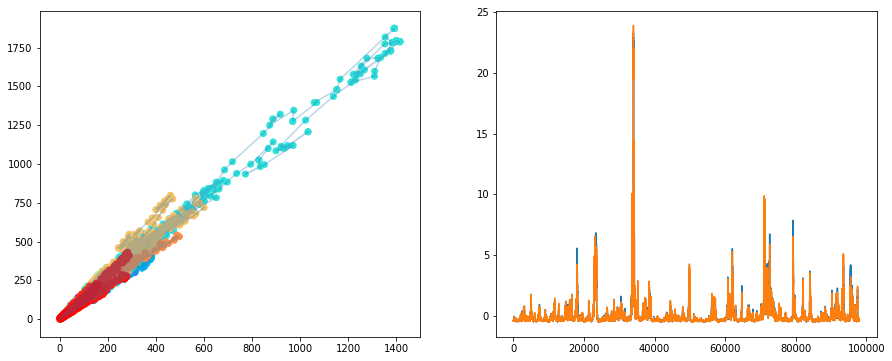

In [131]:
plot(np.exp(samples[2000::1]))

In [ ]:
x = np.linspace(0, 1, 100)
y = sps.beta(0.16, 0.38).pdf(x)
plt.plot(x, y)

In [7]:
"""
import pickle

with open('chain.pkl', 'wb') as output:
    pickle.dump(chains, output, pickle.HIGHEST_PROTOCOL)
"""

In [133]:
import pickle

with open('chain.pkl', 'rb') as input_:
    chains = pickle.load(input_)

FileNotFoundError: [Errno 2] No such file or directory: 'chain.pkl'

In [4]:
len(chains)

22

In [5]:
for ch in chains:
    print (len(ch))

1000
1500
2250
3375
5062
7593
11390
17085
25628
38443
57665
86497
129746
194619
291929
437893
656840
985261
1477891
2216837
3325256
4987885


In [132]:
start = 10000
for ch in chains:
    if len(ch) > start:
        print(len(ch))
        samples = ch[start::300]
        
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.plot(samples[:, 0], samples[:, 1], alpha=0.3)
        plt.scatter(samples[:, 0], samples[:, 1], c=rainbow(np.linspace(0, 1, samples.shape[0])))

        plt.subplot(1, 2, 2)
        plt.plot((samples[:, 0] - samples[:, 0].mean()) / samples[:, 0].std())
        plt.plot((samples[:, 1] - samples[:, 1].mean()) / samples[:, 1].std())
        plt.show()

В целом, это уже похоже на распределение плотности. Значит разумный размер burnin -- 10^6